In [303]:
import tensorflow as tf
import numpy as np 
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import metrics
from pickle import dump
from pickle import load
import joblib
import re
import sweetviz as sv
import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance 
final_date = '2021-01-18'
# target_ToolGID = 'PK_DUVKrF'
# target_ToolGID = 'XE_Sorter'
target_ToolGID = 'MA_Alps'
# target_ToolGID = 'PW_PIX'

In [304]:
def iqrfilter(df, colname, bounds = [.25, .75]):
    s = df[colname]
    Q1 = df[colname].quantile(bounds[0])
    Q3 = df[colname].quantile(bounds[1])
    IQR = Q3 - Q1
    # print(IQR,Q1,Q3,Q1 - 1.5*IQR,Q3+ 1.5 * IQR)
    if bounds[0]==0:
        return df[~s.clip(*[Q1,Q3+ 1.5 * IQR]).isin([Q1,Q3+ 1.5 * IQR])]
    else:
        return df[~s.clip(*[Q1 - 1.5*IQR,Q3+ 1.5 * IQR]).isin([Q1 - 1.5*IQR,Q3+ 1.5 * IQR])]

In [305]:

def build_model(hp):
    
    # from tensorflow.keras import layers
    from kerastuner.tuners import RandomSearch
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32),
                           activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

## NN 模型

In [306]:
def tuningNN(load_model,x,y):
    #tf.keras.wrappers.scikit_learn.KerasClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.metrics import make_scorer
    from sklearn.metrics import accuracy_score, precision_score, recall_score,r2_score
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
    # randcv = RandomizedSearchCV(estimator=MyNN(lr=0.005,nfirst=10,nhidden1=10,nhidden2=0,dropout=0.2,output_bias=0.1,batch_size=100,epochs=1),\
    #                             param_distributions=dict( epochs=[ 50,100,200], batch_size=[ 10,100],nhidden1=[2,5,10],nfirst=[10,20],dropout=[0.2],output_bias=[0.1,0.9],scale_pos_weight=[1,10]),\
    #                             n_iter=30, scoring='f1', n_jobs=1, cv=cv, verbose=1).fit(dftrain[xs], dftrain['y'])

    # pd.DataFrame(randcv.cv_results_).sort_values(by='mean_test_score',ascending=False)
    build_model = lambda: load_model
    Kmodel = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_model, verbose=1)
    scorers = {
        # 'precision_score': make_scorer(precision_score),
        # 'recall_score': make_scorer(recall_score),
        # 'accuracy_score': make_scorer(accuracy_score)
        'r2_score':make_scorer(r2_score)
        }
        #layers=[[8,16,20],  [45, 30, 15]],


#     distributions = {
# "n_hidden": [0, 1, 2, 3],
# "n_neurons": np.arange(1, 100).tolist(),
# "learning_rate": np.arange(3e-4, 3e-2).tolist()
# }

    distributions = dict(batch_size = [ 50,64,75,100], epochs = [50, 75,100] #  , optimizer=['rmsprop', 'adam']#hidden_layers=[[64], [32]]
    )
    #     batch_size = [10, 20, 40, 60, 80, 100]
#     epochs = [10, 50, 100]
    # activations = ['relu'], 
    # param_grid = dict(layers=layers, activation=activations, batch_size = [128, 256], epochs=[30])
    # grid = GridSearchCV(estimator=Kmodel, param_grid=param_grid, cv=5)


    clf = RandomizedSearchCV(Kmodel, distributions, scoring=scorers,random_state=0,n_iter = 5, cv = 2, verbose=10,refit='r2_score')

    from joblib import Parallel, delayed, parallel_backend
    with parallel_backend('threading',n_jobs=12):
        search = clf.fit(x, y)
    
    # print("RandomizedSearchCV took %.2f seconds for %d candidates"
    #       " parameter settings." % ((time() - start), n_iter_search))
    print(clf.best_estimator_.model) 
    # 評估，打分數
    print(f"最佳準確率: {clf.best_score_}，最佳參數組合：{clf.best_params_}")
    # 取得 cross validation 的平均準確率及標準差
    # means = clf.cv_results_['mean_test_score']
    # stds = clf.cv_results_['std_test_score']
    # params = clf.cv_results_['params']
    # for mean, stdev, param in zip(means, stds, params):
    #     print(f"平均準確率: {mean}, 標準差: {stdev}, 參數組合: {param}")
    print(clf.cv_results_)

    # {'mean_fit_time': array([ 9.92220247, 11.41317749,  8.51325178,  5.53384042,  6.71829283]), 
    # 'std_fit_time': array([0.15850294, 0.2024827 , 0.09449553, 0.07199621, 0.11651003]), 
    # 'mean_score_time': array([0.39148962, 0.26898944, 1.17896593, 0.75547612, 0.40098655]), 
    # 'std_score_time': array([0.09949863, 0.17497933, 0.10899651, 0.0884949 , 0.03799713]), 
    # 'param_epochs': masked_array(data=[100, 100, 50, 30, 30],
    #          mask=[False, False, False, False, False],
    #    fill_value='?',
    #         dtype=object), 'param_batch_size': masked_array(data=[64, 32, 32, 64, 32],
    #          mask=[False, False, False, False, False],
    #    fill_value='?',
    #         dtype=object), 'params': [{'epochs': 100, 'batch_size': 64}, {'epochs': 100, 'batch_size': 32}, {'epochs': 50, 'batch_size': 32}, {'epochs': 30, 'batch_size': 64}, {'epochs': 30, 'batch_size': 32}], 'split0_test_r2_score': array([-1.42770799, -1.4276857 , -1.4277966 , -1.42778419, -1.42786533]), 'split1_test_r2_score': array([-1.87841303, -1.87841303, -1.87872848, -1.87892689, -1.87892689]), 'mean_test_r2_score': array([-1.65306051, -1.65304937, -1.65326254, -1.65335554, -1.65339611]), 'std_test_r2_score': array([0.22535252, 0.22536367, 0.22546594, 0.22557135, 0.22553078]), 'rank_test_r2_score': array([2, 1, 3, 4, 5])}
 

    return clf.best_estimator_.model

# 繪製模型預測圖

In [307]:
def drawModelResult(modelType,TOOLG_ID,x,y_actual,y_predict28 , y_predict_actrual,imagepath):

    plt.figure(figsize=(6, 5))# 设置图片尺寸
    plt.title('TOOLG_ID:'+ TOOLG_ID+ " ("+modelType+")")
    # t = np.arange(len(X_dropped))# 创建t变量
    plt.plot(x, y_actual, 'b', linewidth=1, marker='.', label='actual') # 绘制y_test曲线
    plt.plot(x, y_predict28, 'r', linewidth=1, marker='.', label='predict on 28 days') # 绘制predict曲线
    plt.plot(x, y_predict_actrual, 'k', linewidth=1, marker='.', label='predict on actual') # 绘制predict曲线
    plt.legend()
        # target_ToolGID = 'PK_DUVKrF'
    # target_ToolGID = 'XE_Sorter'
    # target_ToolGID = 'MA_Alps'
    # target_ToolGID = 'PW_PIX'
    if TOOLG_ID=='PK_DUVKrF' :
        plt.yticks(np.linspace(0.15,0.45,9))
    elif TOOLG_ID=='XE_Sorter' :
        plt.yticks(np.linspace(0.0,0.12,9))
    elif TOOLG_ID=='MA_Alps' :
        plt.yticks(np.linspace(0.0,0.5,9))
    elif TOOLG_ID=='PW_PIX' :
        plt.yticks(np.linspace(0.0,0.1,9))    
    plt.savefig(imagepath)

In [308]:
# def tunningNN(create_model,X,Y):
    
#     model = KerasClassifier(build_fn=create_model, verbose=0)
#     # define the grid search parameters
#     batch_size = [10, 20, 40, 60, 80, 100]
#     epochs = [10, 50, 100]
#     param_grid = dict(batch_size=batch_size, nb_epoch=epochs)
#     grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
#     grid_result = grid.fit(X, Y)
#     # summarize results
#     print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#     for params, mean_score, scores in grid_result.grid_scores_:
#         print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

In [309]:
def trainNN(df):
    import tensorflow as tf
    save_model_tool = './NN/training_model2.h5'
    # save_model_tool = getSavePath(df['TOOLG_ID'].iloc[0],save_model)
    df_result = df.copy(deep=False)
    X_dropped, Y_dropped = preHandleDat(df_result,True)
    # tuneNN(X_dropped,Y_dropped)
    
    # 拆分train validation set NN fit 可以自己拆
    # X_train, X_test,y_train,y_test = train_test_split(X_dropped,Y_dropped,test_size =0.1,random_state=587)
    
    #1.建立模型(Model)
    #將Layer放入Model中
    # Activation Functions
    # A.softmax：值介於 [0,1] 之間，且機率總和等於 1，適合多分類使用。
    # B.sigmoid：值介於 [0,1] 之間，且分布兩極化，大部分不是 0，就是 1，適合二分法。
    # C.Relu (Rectified Linear Units)：忽略負值，介於 [0,∞] 之間。
    # D.tanh：與sigmoid類似，但值介於[-1,1]之間，即傳導有負值。
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=16,input_shape=[X_dropped.shape[1]]), # units：输出维度
        # tf.keras.layers.Dense(units=32),
        # tf.keras.layers.Dense(units=64),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Dense(units=32),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Dense(units=1)

        
        tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),
        # tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),

        #tf.keras.layers.Dense(units=1)
        tf.keras.layers.Dense(units=1, kernel_initializer='random_uniform',activation='relu')
        

        ])
    #model.summary()
    #======================================================================================
    # 定義 tensorboard callback
    tensorboard_callback = [tf.keras.callbacks.TensorBoard(log_dir='D:/Projects/AI/POC/homework/logs2')]
    #======================================================================================
    #2. 確立目標及求解方法：以compile函數定義損失函數(loss)、優化函數(optimizer)及成效衡量指標(mertrics)。

        #compile()方法來指定損失函數與優化函數，也可以額外指定一系列的訓練和評估期間計算評量標準
        #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  
        
        # # model.compile( loss = root_mean_squared_error,optimizer = "rmsprop",metrics =["accuracy"],callbacks=tensorboard_callback) 
        # model.compile(loss = root_mean_squared_error,metrics =["accuracy"],callbacks=tensorboard_callback) 
        # 
    #--------------------------
    #[Keras 損失函數(loss)]
        #   A.均方誤差(mean_squared_error)----mean_squared_error-------------------------------
        #   B.Hinge Error (hinge)：是一種單邊誤差，不考慮負值，適用於『支援向量機』(SVM)的最大間隔分類法(maximum-margin classification)
        #  C.Cross Entropy (categorical_crossentropy)：當預測值與實際值愈相近，損失函數就愈小，反之差距很大，就會更影響損失函數的值，這篇文章 主張要用 Cross Entropy 取代 MSE，因為，在梯度下時，Cross Entropy 計算速度較快，其他變形包括 sparse_categorical_crossentropy、binary_crossentropy。
        #  D.其他還有 logcosh、kullback_leibler_divergence、poisson、cosine_proximity 等。
    #--------------------------
    #[優化函數(Optimizer)]
    #   A. 隨機梯度下降法(Stochastic Gradient Descent, SGD)：就是利用偏微分，逐步按著下降的方向，尋找最佳解。它含以下參數：
    #        Learning Rate (lr)：逼近最佳解的學習速率，速率訂的太小，計算最佳解的時間花費較長，訂的太大，可能會在最佳解兩                               旁擺盪，找不到最佳解。
    #        momentum：更新的動能，一開始學習速率可以大一點，接近最佳解時，學習速率步幅就要小一點，一般訂為0.5，不要那麼大時，可改為 0.9。
    #        decay：每次更新後，學習速率隨之衰減的比率。
    #        nesterov：是否使用 Nesterov momentum，請參考 http://blog.csdn.net/luo123n/article/details/48239963 。
    #  B.Adam：一般而言，比SGD模型訓練成本較低，請參考『Adam - A Method for Stochastic Optimization』，包含相關參數建議值，含以下參數：

    #        lr：逼近最佳解的學習速率，預設值為0.001。
    #        beta_1：一階矩估計的指數衰減因子，預設值為0.9。
    #        beta_2：二階矩估計的指數衰減因子，預設值為0.999。
    #        epsilon：為一大於但接近 0 的數，放在分母，避免產生除以 0 的錯誤，預設值為1e-08。
    #        decay：每次更新後，學習速率隨之衰減的比率。
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01)
    #                     , metrics= ['accuracy'],callbacks=tensorboard_callback) 
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD()
    #                     , metrics= ['accuracy'],callbacks=tensorboard_callback) 
    #========================================================================
    # SGD
    sgd = tf.keras.optimizers.SGD(lr=0.20, momentum=0.0, decay=0.0, nesterov=False)
    # 随机梯度下降优化器。
    # 包含扩展功能的支持： - 动量（momentum）优化, - 学习率衰减（每次参数更新后） - Nestrov 动量 (NAG) 优化
    # 参数
    # lr: float >= 0. 学习率。
    # momentum: float >= 0. 参数，用于加速 SGD 在相关方向上前进，并抑制震荡。
    # decay: float >= 0. 每次参数更新后学习率衰减值。
    # nesterov: boolean. 是否使用 Nesterov 动量。
    #========================================================================
    # compile 編譯模型
    # model.compile(loss='mean_squared_error', optimizer='adam'
    #                     , metrics= ['accuracy','mse', 'mae', 'mape'],callbacks=tensorboard_callback) 」‘「＝、
    
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(lr=0.01,decay=1e-6, momentum=0.9, nesterov=True)
    #                     , metrics= ['accuracy','mse', 'mae', 'mape'],callbacks=tensorboard_callback) 
    # model.compile(loss=root_mean_squared_error, optimizer=tf.keras.optimizers.Adam(lr=0.01)
    #                     , metrics = [root_mean_squared_error, 'mae', 'mape'])
    
    # model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(lr=0.01)
    #                     , metrics = [root_mean_squared_error, 'mae', 'mape'])   
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(lr=0.01) #, optimizer=tf.keras.optimizers.SGD(lr=0.2)
                        , metrics = [ 'mae', 'mape'])   
    
    # model = tuningNN(model,X_dropped,Y_dropped)                                            
    #======================================================================================

    #3.訓練 fit：以compile函數進行訓練，指定訓練的樣本資料(x, y)，並撥一部分資料作驗證，還有要訓練幾個週期、訓練資料的抽樣方式。
    # train_history = model.fit(x=X_dropped, y=Y_dropped,
    #                validation_data=(X_dropped_test, Y_dropped_test), # Use this instead
    #                 epochs=50, batch_size=30, verbose=2) #validation_split=0.1, 用最後的10%資料驗證 batch_size=200: 每一批次200筆資料 verbose=2: 顯示訓練過程
    train_history = model.fit(x=X_dropped, y=Y_dropped,
                #validation_data=(X_dropped_test, Y_dropped_test), # Use this instead
                validation_split=0.10, epochs=50, batch_size=75, verbose=0) #,shuffle=True validation_split=0.1, 用最後的10%資料驗證 batch_size=200: 每一批次200筆資料
    # early_stopping = tf.keras.callbacks.EarlyStopping(patience=25)
    # train_history = model.fit(x=X_dropped, y=Y_dropped, validation_split=0.1, epochs=200, batch_size=30, verbose=2)
    # train_history = model.fit(X_dropped, Y_dropped, epochs=20, verbose=True)
    
    model.save(save_model_tool)
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))

    #評估(Evaluation)：訓練完後，計算成效。
    # 顯示訓練成果(分數)
    # scores = model.evaluate(X_dropped, Y_dropped) 
    
    # print("Finished training the model",scores)
    print(train_history.history.keys())
    #dict_keys(['loss', 'accuracy', 'mse', 'mae', 'mape', 'val_loss', 'val_accuracy', 'val_mse', 'val_mae', 'val_mape'])
    
    # 當RMSE收斂至接近0.02，且MAPE接近10%，即完成模型之訓練
    figure, axis_1 = plt.subplots()
    plt.title(df['TOOLG_ID'].iloc[0]) # title
    plt.xlabel('Epoch Number')
    plt.ylabel("Loss Magnitude")

    loss = axis_1.plot(train_history.history['loss'], label = 'loss')

    #plt.ylabel("accuracy")
    # ac =axis_1.plot(train_history.history['accuracy'], label = 'accuracy' )# 準確度
    # ac =axis_1.plot(train_history.history['mse'], label = 'mse' )# 準確度
    
    
    
    # mse = axis_1.plot(train_history.history['mse'], label = 'mse' ) 
    # vallossaxis_1= axis_1.plot(train_history.history['val_loss'], label = 'val_loss' )# 準確度
    axis_2 = axis_1.twinx()
    # mse = axis_2.plot(train_history.history['mse'], label = 'mse',color='red' ) 
    mse = axis_2.plot(train_history.history['mape'], label = 'mape',color='red' ) 
    
    # mape = axis_2.plot(train_history.history['mape'], label = 'mape' )# 準確度 接近10%
        
    axis_1.legend(loc='upper left',fontsize='large')
    axis_2.legend(loc='upper right',fontsize='large')
    # plt.legend((ac, valloss, mse, mape),
    #        ('Low accuracy', 'val_loss', 'mse', 'mape'),
    #        scatterpoints=1,
    #        loc='upper right',
    #     #    ncol=3,
    #        fontsize=14)

    plt.show()

    from sklearn.metrics import mean_squared_error #均方誤差
    from sklearn.metrics import mean_absolute_error #平方絕對誤差
    from sklearn.metrics import r2_score#R square
    #呼叫
    y_predict = model.predict(X_dropped)
    #print(np.count_nonzero(~np.isnan(Y_dropped)),np.count_nonzero(~np.isnan(y_predict)))
    Y_dropped = np.nan_to_num(np.nan, copy=True)
    # Y_dropped = np.nan_to_num(np.nan, copy=True)
    
    # print("mean_squared_error",mean_squared_error(Y_dropped,y_predict))
    # print("mean_absolute_error",mean_absolute_error(Y_dropped,y_predict))
    # print("r2_score",r2_score(Y_dropped,y_predict))
    #return df_test_eh

In [310]:
def testNN(df,df_real):
    import tensorflow as tf
    save_model_tool = './NN/training_model2.h5'
    model = tf.keras.models.load_model(save_model_tool)
    df_result=df.copy(deep=True)
    
    X_dropped,Y_dropped = preHandleDat(df,False)
    y_predict = model.predict(X_dropped)
    df_result['predict'] = y_predict # 預測
    

    df_result_real=df_real.copy(deep=True)
    X_dropped_real,Y_dropped_real = preHandleDat(df_result_real,False)
    y_predict_real = model.predict(X_dropped_real)
    df_result_real['predict'] = y_predict_real # 預測


    # df.plot.scatter(x ='NO_HOLD_QTY', y='predict')#,style='o',figsize=(10,5), grid=True  )
    # ax.locator_params(integer=True)
    
   
 
    # plt.figure(figsize=(6, 5))# 设置图片尺寸
    # plt.title('TOOLG_ID:'+ df['TOOLG_ID'].iloc[0] + " (NN)")
    # # t = np.arange(len(X_dropped))# 创建t变量
    # plt.plot(df_result['MFG_DATE'], Y_dropped, 'b', linewidth=1, marker='.', label='actual') # 绘制y_test曲线
    # plt.plot(df_result['MFG_DATE'], y_predict, 'r', linewidth=1, marker='.', label='predict on 28 days') # 绘制predict曲线
    # plt.plot(df_result_real['MFG_DATE'], y_predict_real, 'k', linewidth=1, marker='.', label='predict on actual') # 绘制predict曲线
    # plt.legend()
    # # plt.yticks(np.linspace(0.0,0.8,9))
    # plt.savefig('./Result/NNtest2.png')

    
    drawModelResult('NN',df['TOOLG_ID'].iloc[0],df_result['MFG_DATE'],Y_dropped, y_predict,y_predict_real,'./Result/NNtest2.png')

    return df_result

## XG 模型

In [311]:
def trainXG(df):
    import xgboost as xgb
    
    import joblib

    X,Y = preHandleDat(df,True)
    
    #拆分train validation set
    X_train, X_test,y_train,y_test = train_test_split(X,Y,test_size =0.2,random_state=587)
    cv_params = {'n_estimators': [300,400,500,600],'max_depth':[7,11,13,15,17],'min_child_weight':[1,3,5,7,9]}
    other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
    model = xgb.XGBRegressor(**other_params)
    optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)

    optimized_GBM.fit(X_train, y_train) 

    test_score = optimized_GBM.score(X_test,y_test)

    print('test 得分:{0}'.format(test_score))
    # evalute_result = optimized_GBM.grid_scores_
    # print('每輪迭代執行結果:{0}'.format(evalute_result))
    
    print('引數的最佳取值：{0}'.format(optimized_GBM.best_params_))
    print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
    print('cv_results_',optimized_GBM.cv_results_)

    bst_model = optimized_GBM.estimator
    print(bst_model)

    
    bst_model.fit(X_train, y_train)
    plot_importance(bst_model)#,max_num_features=10)
    plt.show()

    joblib.dump(bst_model, 'XG_model')

In [312]:
def testXG(df,df_real):
    X_test,y_test = preHandleDat(df,False)
    # print(X_test)
    #print(X_test,y_test)
    df_result=df.copy(deep=True)
    loaded_model = joblib.load('XG_model')
    y_predict = loaded_model.predict(X_test)
    df_result['predict'] = y_predict
    
    loaded_model.score(X_test, y_test)
    print("r2:", loaded_model.score(X_test, y_test))
    
    df_result_real=df_real.copy(deep=True)
    X_dropped_real,Y_dropped_real = preHandleDat(df_result_real,False)
    y_predict_real = loaded_model.predict(X_dropped_real)
    df_result_real['predict'] = y_predict_real # 預測


    # # y_test real 与 y_predict的可视化
    # plt.figure(figsize=(6, 5))# 设置图片尺寸
    # plt.title('TOOLG_ID:'+ df['TOOLG_ID'].iloc[0] + " (XG)")
    # # t = np.arange(len(X_test))# 创建t变量
    # # plt.plot(df_result['MFG_DATE'], y_test, 'r', linewidth=1, marker='.', label='real') # 绘制y_test曲线
    # # plt.plot(df_result['MFG_DATE'], y_predict, 'g', linewidth=1, marker='.', label='predict') # 绘制predict曲线
    # # plt.plot(df_result_real['MFG_DATE'], y_predict_real, 'k', linewidth=1, marker='.', label='real predict') # 绘制predict曲线
    # #predict base on 28 days
    # plt.plot(df_result['MFG_DATE'], y_test, 'b', linewidth=1, marker='.', label='actual') # 绘制y_test曲线
    # #actural
    # plt.plot(df_result['MFG_DATE'], y_predict, 'r', linewidth=1, marker='.', label='predict on 28 days') # 绘制predict曲线
    # #predict base on real
    # plt.plot(df_result_real['MFG_DATE'], y_predict_real, 'k', linewidth=1, marker='.', label='predict on actual') 
    # plt.legend()
    # # plt.yticks(np.linspace(0.0,0.8,9))
    # plt.savefig('./Result/XGtest2.png')

    drawModelResult('XG',df['TOOLG_ID'].iloc[0],df_result['MFG_DATE'],y_test, y_predict,y_predict_real,'./Result/XGtest2.png')

    
    return df_result

### normalize 釋義:是否對數據進行標準化處理
設置:bool型,可選,默認False,建議將標準化的工作放在訓練模型之前,通過設置sklearn.preprocessing.StandardScaler來實現，而在此處設置為false 當fit_intercept設置為false的時候，這個參數會被自動忽略。如果為True,回歸器會標準化輸入參數：減去平均值，並且除以相應的二範數


### copy_X 釋義:是否對X複製
設置:bool型、可選、默認True,如為false，則即經過中心化，標準化後，把新數據覆蓋到原數據上

### n_jobs釋義:計算時設置的任務個數,
這一參數的對於目標個數>1（n_targets>1）且足夠大規模的問題有加速作用
設置:int or None, optional, 默認None,如果選擇-1則代表使用所有的CPU。


## LR 模型

In [313]:
def trainLR(df):
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    import joblib

    X,Y = preHandleDat(df,True)
    
    #拆分train validation set
    X_train, X_test,y_train,y_test = train_test_split(X,Y,test_size =0.01,random_state=123)
    
    model = LinearRegression(fit_intercept=False, normalize=False, copy_X=False) #fit_intercept=False
   
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    
    #print(y_predict)
    print("r2:", model.score(X_test, y_test))# 拟合优度R2的输出方法
    print("MAE:", metrics.mean_absolute_error(y_test, y_predict))# 用Scikit_learn计算MAE
    print("MSE:", metrics.mean_squared_error(y_test, y_predict)) # 用Scikit_learn计算MSE
    print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_predict)))# 用Scikit_learn计算RMSE
    print("intercept_ :",model.intercept_)
    # print("coef_", model.coef_)
    joblib.dump(model, 'LR_model')
    # print(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))#計算準確率分數)

    # print((y_predict-y_test)/y_test)


    
    # reg = LinearRegression().fit(X, y)
 
    # line_poly = poly.transform(line)
    # plt.plot(line, reg.predict(line), label='linear regression')
    # plt.plot(X[:, 0], y, 'o', c='k')
    # plt.ylabel("Regression output")
    # plt.xlabel("Input feature")
    # plt.legend(loc="best")
 

    return y_predict

In [314]:
def testLR(df,df_real):
    from sklearn.linear_model import LinearRegression
    
    X_test,y_test = preHandleDat(df,False)
    # print(X_test)
    #print(X_test,y_test)
    loaded_model = joblib.load('LR_model')
    y_predict = loaded_model.predict(X_test)
    df_result=df.copy(deep=True)
    df_result['predict'] = y_predict
    
    loaded_model.score(X_test, y_test)
    print("r2:", loaded_model.score(X_test, y_test))
    
    df_result_real=df_real.copy(deep=True)
    X_dropped_real,Y_dropped_real = preHandleDat(df_result_real,False)
    y_predict_real = loaded_model.predict(X_dropped_real)
    df_result_real['predict'] = y_predict_real # 預測


    


    # # y_test real 与 y_predict的可视化
    # plt.figure(figsize=(6, 5))# 设置图片尺寸
    # # t = np.arange(len(X_test))# 创建t变量
    # plt.title('TOOLG_ID:'+ df['TOOLG_ID'].iloc[0] + " (LR)")
    # # plt.plot(df_result['MFG_DATE'], y_test, 'r', linewidth=1, marker='.', label='real') # 绘制y_test曲线
    # # plt.plot(df_result['MFG_DATE'], y_predict, 'g', linewidth=1, marker='.', label='predict') # 绘制predict曲线
    # # plt.plot(df_result_real['MFG_DATE'], y_predict_real, 'k', linewidth=1, marker='.', label='real predict') # 绘制predict曲线
    # plt.plot(df_result['MFG_DATE'], y_test, 'b', linewidth=1, marker='.', label='actual') # 绘制y_test曲线
    # plt.plot(df_result['MFG_DATE'], y_predict, 'r', linewidth=1, marker='.', label='predict on 28 days') # 绘制predict曲线
    # plt.plot(df_result_real['MFG_DATE'], y_predict_real, 'k', linewidth=1, marker='.', label='predict on actual') 
    # plt.legend()
    # # plt.yticks(np.linspace(0.0,0.8,9))
    # plt.savefig('./Result/test2.png')


    drawModelResult('LR',df['TOOLG_ID'].iloc[0],df_result['MFG_DATE'],y_test, y_predict,y_predict_real,'./Result/LR.png')

    return df_result


# 資料 預處理 preHandleDat()

In [315]:
def preHandleDat(df,isTrain=True):
    from sklearn.preprocessing import StandardScaler #平均&變異數標準化 平均值為0，方差為1。
    from sklearn.preprocessing import MinMaxScaler #最小最大值標準化[0,1]
    from sklearn.preprocessing import RobustScaler #中位數和四分位數標準化
    from sklearn.preprocessing import MaxAbsScaler #絕對值最大標準化

    #=================
    #刪除不必要的欄位
    #=================
    drop_cols=['MFG_DATE','ARRIVAL_WIP_QTY','MOVE_QTY','PROCESS_TIME','C_TC','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE']
    num_cols=['M_NUM','EQP_UTIL','C_EQP_UTIL','U','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','NO_HOLD_QTY','WIP_QTY','IS_HOLIDAY','RUN_WIP_RATIO'] 
    target_cols=['TRCT']
    cat_cols = ['TOOLG_ID']
    df = df.drop(drop_cols, axis=1)
    #df_train['Finish']=np.where(df_train['TOOLG_ID_NEXT'].isnull(), 1, 0).astype(str)
    #df_train['WEEKDAY']=pd.to_datetime(df_train['MFG_DATE'],format='%Y%m%d').dt.day_name()
    # df['MFG_DATE']=pd.to_datetime(df_train['MFG_DATE'],format='%Y%m%d')
    #'IS_HOLIDAY'
     
    # df = df.drop('WIP_QTY', axis=1)
    # df = df.sort_values('NO_HOLD_QTY')
    # print("DATA Start====")
    # print(df.info())  
    #========================
    # 缺漏值填空
    #========================
    df = df.fillna(df.median())
    #df = df.fillna(method='bfill') #往後
    # df = df.fillna(method='ffill') #往前
    # df = df.fillna(df.mean())  #用平均值取代 nan   
    # df = df.dropna() # 刪除null值   
    #df['ColA'].fillna(value=0, inplace=True) #用 0 取代 nan
    #df['ColA'].fillna(value=df.groupby('ColB')['ColA'].transform('mean'), inplace=True) #利用 groupby()同一group 的平均值

    #==================================================
    #1.特徵縮放
    #==================================================
    
    #特徵縮放欄位 List(排除Target TRCT)==================
    # num_cols=['M_NUM','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY','MOVE_QTY','ARRIVAL_WIP_QTY','RUN_WIP_RATIO','CLOSE_WIP_QTY','MANAGEMENT_WIP_QTY','C_TC','C_CLOSE_WIP','C_TOOLG_LOADING','C_TOOL_LOADING','DISPATCHING','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','[BACKUP]','REWORK_RATE','QUE_LOT_RATE','SAMPLING_RATE','NUM_RECIPE','CHANGE_RECIPE','BATCH_SIZE']

   #'ARRIVAL_WIP_QTY',,'WIP_QTY'
    df_train_scal = df.copy(deep=False)
    global df_cols
    df_cols = df_train_scal.columns
    
    if isTrain:
        
        
        #rescaling 特徵縮放 StandardScaler-------------------------------------
        # scaler = StandardScaler()
        # scaler.fit(df_train[num_cols])
        # df_train_scal[num_cols]= scaler.transform(df_train_scal[num_cols])
    
        #rescaling 特徵縮放 MinMaxScaler-------------------------------------
        scaler = MinMaxScaler()
        scaler.fit(df[num_cols])
        df_train_scal[num_cols]= scaler.transform(df_train_scal[num_cols])

        #rescaling 特徵縮放 RobustScaler-------------------------------------
        # scaler = RobustScaler()
        # scaler.fit(df_train[num_cols])
        # df_train_scal[num_cols] = scaler.transform(df_train_scal[num_cols])
        
       
        dump(scaler, open('scaler.pkl', 'wb'))
        # # save the scaler
        # dump(scaler, open('scaler.pkl', 'wb'))
    else:
        # load the scaler
        scaler = load(open('scaler.pkl', 'rb'))
        df_train_scal[num_cols] = scaler.transform(df[num_cols])



     #==================================================
    #2.one hot encoder
    #==================================================
    # target_cols=['MOVE_QTY']
 
    global df2_train_eh_before
    df_train_eh =pd.get_dummies(df_train_scal.drop(target_cols, axis=1),columns=cat_cols)
    # save the scaler


    if isTrain:
        df2_train_eh_before = df_train_eh.copy(deep=False)
    else:
        df_train_eh = df_train_eh.reindex(columns = df2_train_eh_before.columns, fill_value=0)

    df_train_scal.to_csv('./df_train_scal.csv')
    #print(df_train_scal.drop(target_cols, axis=1).describe())
    # print("one hot encoder====")
    # print(df_train_eh.info())


    # df_test_eh=pd.get_dummies(df.drop('MOVE_QTY', axis=1))
    #df_test_eh = df_test_eh.reindex(columns = df_test_eh.columns, fill_value=0)
   
    #np.asarray(x).astype('float32')        
           
    X_dropped = np.asarray(df_train_eh)

    Y_dropped = np.asarray(df[target_cols]) 
    return X_dropped,Y_dropped
    

In [316]:
def readDataFromFile(file_path):
    _df = pd.read_csv(file_path)
    return _df

In [317]:
def EDA(df_train,targetfeat='MOVE_QTY'):
    
    pairwise_analysis='on' #相關性和其他型別的資料關聯可能需要花費較長時間。如果超過了某個閾值，就需要設定這個引數為on或者off，以判斷是否需要分析資料相關性。
    report_train = sv.analyze([df_train, 'train'],
                                    target_feat= targetfeat,
                                    pairwise_analysis = pairwise_analysis
    )
    report_train.show_html(filepath='./sweetvizHTML/train_report.html' ) # 儲存為html的格式

    # compare_subsets_report = sv.compare_intra(df_train,
    #                                         df_train['Finish']==1, # 給條件區分
    #                                         ['Finish', 'notFinish'], # 為兩個子資料集命名 
    #                                         target_feat='NO_HOLD_QTY',
    #                                         )

    # compare_subsets_report.show_html(filepath='./sweetvizHTML/HW2_Compare_report.html')

In [318]:
df_train_orign=readDataFromFile('./data/TRCT_TrainingData_20210131.csv')
 
df_train_orign = df_train_orign.loc[df_train_orign['TOOLG_ID']==target_ToolGID]
#df_train_orign['MFG_DATE'] = pd.to_datetime(test['MFG_DATE'],format='%Y%m%d') 
df_train_orign['MFG_DATE'] = df_train_orign['MFG_DATE'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

df_train = df_train_orign



# df_train.info()
# 1. 查看缺失情况
# print(df_train.isnull().sum())
# print(df_train.describe())# 128683

#df2_test = df2_test.dropna()# 刪除null值

# 'MFG_DATE','TOOLG_ID','IS_HOLIDAY','M_NUM','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY','MOVE_QTY','ARRIVAL_WIP_QTY','RUN_WIP_RATIO','CLOSE_WIP_QTY','MANAGEMENT_WIP_QTY','C_TC','C_CLOSE_WIP','C_TOOLG_LOADING','C_TOOL_LOADING','DISPATCHING','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','[BACKUP]','REWORK_RATE','QUE_LOT_RATE','SAMPLING_RATE','NUM_RECIPE','CHANGE_RECIPE','BATCH_SIZE'
# num_cols=['WIP_QTY','NO_HOLD_QTY','M','U','PT','UP_TIME','EQP_UTIL','TC','CS','AI','C_AI']
# missData(df_train)

#刪除columns 值是空的()
df_train = df_train.dropna(axis=1, how='all')
 
# #刪除rows ,target值是空的()
df_train = df_train[df_train['MOVE_QTY'].notna()]
df_train = df_train[df_train['NO_HOLD_QTY'].notna()]
# df_train['TRCT']= df_train['NO_HOLD_QTY']/df_train['MOVE_QTY']
df_train['TRCT']= df_train['NO_HOLD_QTY']/df_train['MOVE_QTY']



df_train.info()

print(df_train.isnull().sum())
#df_train.info()
# 檢查資料處理  value  是不是有 無限大
# x,y=preHandleDat(df_train)
 
# # # np.isnan(y.any()) #and gets False
# # # np.isfinite(y.all()) #and gets True

# print(np.all(np.isfinite(x)))
# print(np.all(np.isfinite(y)))

# #trainLR(df_train)

#刪除outlier
# df_train =iqrfilter(df_train,'M_NUM',[0.25, 1]) 
# df_train =iqrfilter(df_train,'PROCESS_TIME',[0.25, 1]) 
df_train =iqrfilter(df_train,'TRCT',[.25, 1 /;;;;;;;;;;.................fv]) 
 
df_train['PROCESS_TIME'].replace(0, np.nan, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 209 to 128207
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MFG_DATE         342 non-null    datetime64[ns]
 1   TOOLG_ID         342 non-null    object        
 2   IS_HOLIDAY       342 non-null    float64       
 3   M_NUM            342 non-null    float64       
 4   UP_TIME          342 non-null    float64       
 5   C_UP_TIME        342 non-null    float64       
 6   LOT_SIZE         342 non-null    float64       
 7   C_LOT_SIZE       342 non-null    float64       
 8   EQP_UTIL         342 non-null    float64       
 9   C_EQP_UTIL       342 non-null    float64       
 10  U                342 non-null    float64       
 11  PROCESS_TIME     342 non-null    float64       
 12  WIP_QTY          342 non-null    float64       
 13  NO_HOLD_QTY      342 non-null    float64       
 14  MOVE_QTY         342 non-null    floa

## 資料分析 Tool

In [319]:

#資料分析 Tool
# EDA(df_train,'TRCT')

In [320]:

# df_train1 = df_train[df_train['MFG_DATE'] <  pd.to_datetime('2021-01-20')]
df_train1 = df_train[df_train['MFG_DATE'] <  pd.to_datetime(final_date)]

# df_train1 =iqrfilter(df_train1,'M_NUM',[0.25, 1]) 
df_train1['MFG_DATE'].max()


Timestamp('2021-01-17 00:00:00')

# 模型 訓練

In [321]:
# EDA(df_train1,'TRCT')

# 推估當天 28天 df_sum28

##取得當天的生產資訊
#### C_LOT_SIZE
#### LOT_SIZE
#### PROCESS_TIME
#### WIP_QTY
#### NO_HOLD_QTY
#### ARRIVAL_WIP_QTY
#### HOLD_RATE
#### ENG_LOT_RATE
#### HOT_LOT_RATE
#### QUE_LOT_RATE

In [322]:
def getsum28(df_train,final_date):
    
    test = df_train[df_train['MFG_DATE'] <  pd.to_datetime(final_date)]
    # test['MFG_DATE'] = pd.to_datetime(test['MFG_DATE'],format='%Y%m%d') 
    print(test['MFG_DATE'].max())
    df = test.groupby('TOOLG_ID').apply(lambda x: x.set_index('MFG_DATE').resample('1D').first())
    # df = test.groupby('User').apply(lambda x: x.set_index('Date').resample('1D').first())
    num_cols=['M_NUM','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY', 'ARRIVAL_WIP_QTY','RUN_WIP_RATIO','C_TC','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','MOVE_QTY']
    # num_cols=['M_NUM']
    # df1[num_cols] = df.groupby(level=0)[num_cols].apply(lambda x: x.shift().rolling(min_periods=1,window=28).mean())
    # df1 = df.groupby(level=0)['Value']
    #         .apply(lambda x: x.shift().rolling(min_periods=1,window=2).mean())
    #         .reset_index(name='Value_Average_Past_2_days')

    df_sum28 = df.groupby(level=0)[num_cols].apply(lambda x: x.shift().rolling(min_periods=1,window=28).mean()).reset_index()
    
    #df_train1['MFG_DATE'].max()
    df_sum28['MFG_DATE'].max()
    #抓最後一天的數據 來預測當天的值 df_test_today
    df_test_today=df_sum28.loc[df_sum28['MFG_DATE']==df_sum28['MFG_DATE'].max()]
     
    # df_test_today['MFG_DATE'] = df_sum28['MFG_DATE'].max()+ datetime.timedelta(days=1)
    weekno = df_test_today['MFG_DATE'].max().weekday()

    if weekno < 5:
        df_test_today['IS_HOLIDAY'] = 1
    else:  # 5 Sat, 6 Sun
        df_test_today['IS_HOLIDAY'] =1.0527

    real_data_cols_withkeys =['MFG_DATE','TOOLG_ID','C_LOT_SIZE','LOT_SIZE','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY','ARRIVAL_WIP_QTY','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','MOVE_QTY']
    real_data_cols =['C_LOT_SIZE','LOT_SIZE','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY','ARRIVAL_WIP_QTY','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','MOVE_QTY']
    df_map_today = df_train[real_data_cols_withkeys] 
    df_map_today=df_map_today.loc[df_map_today['MFG_DATE']==df_test_today['MFG_DATE'].max()]

    for index, row in df_test_today.iterrows():
        r = df_map_today[real_data_cols].loc[(df_map_today['MFG_DATE']==row['MFG_DATE'])  & (df_map_today['TOOLG_ID']==row['TOOLG_ID'])]
        if(r.any(axis=None)):
            for col in real_data_cols:
                df_test_today.loc[index,col]  =r[col].values
        else:
            df_test_today.drop(index, inplace=True)
        
    #測試集的答案 驗證用
    df_test_today['TRCT']= df_test_today['NO_HOLD_QTY']/df_test_today['MOVE_QTY']
    # df_test_today['TRCT']= df_test_today['MOVE_QTY']
    return df_test_today

In [323]:
# df_train.to_csv('./data/data_train.csv')
# num_cols=['M_NUM','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY', 'ARRIVAL_WIP_QTY','RUN_WIP_RATIO','C_TC','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','MOVE_QTY']
# df_train.groupby('TOOLG_ID').apply(lambda x: x.set_index('MFG_DATE').resample('1D').first()).groupby(level=0)[num_cols].apply(lambda x: x.shift().rolling(min_periods=1,window=28).max()).reset_index().to_csv('./data/data_train28.csv')

# df_train['MFG_DATE'].iloc[0]


In [324]:
#  df_test_today['MFG_DATE'].iloc[0].weekday()

# 訓練資料 抓28天平均 generationTraininDatFrame()

In [325]:
def generationTraininDatFrame(_dfRaw):
    # test = df_train[df_train['MFG_DATE'] <  pd.to_datetime(final_date)]
    test = _dfRaw
    # test.to_csv('./data/dfRaw.csv')
    # test['MFG_DATE'] = pd.to_datetime(test['MFG_DATE'],format='%Y%m%d') 
    # print(test['MFG_DATE'].max())
    df = test.groupby('TOOLG_ID').apply(lambda x: x.set_index('MFG_DATE').resample('1D').first())
    # df = test.groupby('User').apply(lambda x: x.set_index('Date').resample('1D').first())
    num_cols=['M_NUM','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY', 'ARRIVAL_WIP_QTY','RUN_WIP_RATIO','C_TC','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','MOVE_QTY']
    # num_cols=['M_NUM']
    # df1[num_cols] = df.groupby(level=0)[num_cols].apply(lambda x: x.shift().rolling(min_periods=1,window=28).mean())
    # df1 = df.groupby(level=0)['Value']
    #         .apply(lambda x: x.shift().rolling(min_periods=1,window=2).mean())
    #         .reset_index(name='Value_Average_Past_2_days')

    df_sum28 = df.groupby(level=0)[num_cols].apply(lambda x: x.shift().rolling(min_periods=1,window=28).mean()).reset_index()
    #df_train1['MFG_DATE'].max()
    # df_sum28.to_csv('./data/df_sum28.csv')
     
 
    _df_result = pd.DataFrame(columns = df_sum28.columns)
 
    for index, df_sum28_row  in df_sum28.iterrows():
        
        if index<=28:
            continue
        #print(df_sum28_row['MFG_DATE'])
        #df_test_today=df_sum28.loc[df_sum28['MFG_DATE']==df_sum28_row['MFG_DATE']]
        df_test_today=df_sum28_row
        
        # print(df_test_today.head(2))
        #計算 MFG_DATE(移除不需要自己加一天 ， 移動平均算的試當天以前28天不含當日)
        # df_test_today['MFG_DATE'] = df_sum28_row['MFG_DATE'] + datetime.timedelta(days=1)
        # print(df_sum28_row['MFG_DATE'])
        weekno = df_sum28_row['MFG_DATE'].weekday()
        #計算 IS_HOLIDAY
        
        if weekno < 5:
            df_test_today['IS_HOLIDAY'] = 1
        else:  # 5 Sat, 6 Sun
            df_test_today['IS_HOLIDAY'] =1.0527
         

        real_data_cols_withkeys =['MFG_DATE','TOOLG_ID','C_LOT_SIZE','LOT_SIZE','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY','ARRIVAL_WIP_QTY','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','MOVE_QTY']
        real_data_cols =['C_LOT_SIZE','LOT_SIZE','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY','ARRIVAL_WIP_QTY','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','MOVE_QTY']

        #取得當天的WIP 實際資料===========================
        df_map_today = _dfRaw[real_data_cols_withkeys] 
        df_map_today=df_map_today.loc[df_map_today['MFG_DATE']==df_sum28_row['MFG_DATE']]
        df_map_today=df_map_today.loc[df_map_today['TOOLG_ID']==df_sum28_row['TOOLG_ID']] #+ datetime.timedelta(days=1)]
 
       
        # for index, row in df_test_today.iterrows():
        #     print(row)
        #     r = df_map_today[real_data_cols].loc[(df_map_today['MFG_DATE']==row['MFG_DATE'])  & (df_map_today['TOOLG_ID']==row['TOOLG_ID'])]
        # if(df_map_today.any(axis=None)):
        if df_map_today.shape[0]==0:
            continue
        for col in real_data_cols:
            # print(col)
            # print(df_map_today.iloc[0][col])
            df_test_today[col] = df_map_today.iloc[0][col] 
            # df_test_today.loc[index,col]  =df_map_today[col].values
        # else:
        #     df_test_today.drop(index, inplace=True)
            
        #測試集的答案 驗證用
        df_test_today['TRCT']= df_test_today['NO_HOLD_QTY']/df_test_today['MOVE_QTY']
        _df_result = _df_result.append(df_test_today,ignore_index=True)
        # df_test_today['TRCT']= df_test_today['MOVE_QTY']
        # _df_result = iqrfilter(_df_result,'M_NUM',[.25, 1]) 
        
    return _df_result

## 訓練集取28天平均 df_train_sum28 
### df_train_sum28_1 <==區分訓練與驗證


In [326]:

df_train_sum28_org = generationTraininDatFrame(df_train)
print(df_train_sum28_org)
df_train_sum28 = df_train_sum28_org

    TOOLG_ID   MFG_DATE  M_NUM   UP_TIME  C_UP_TIME   LOT_SIZE  C_LOT_SIZE  \
0    MA_Alps 2020-02-20    4.0  0.796522   0.158710  24.333333    0.170070   
1    MA_Alps 2020-02-21    4.0  0.791373   0.159770  22.162162    0.186280   
2    MA_Alps 2020-02-22    4.0  0.775242   0.164124  23.486486    0.176583   
3    MA_Alps 2020-02-23    4.0  0.771186   0.164752  22.628571    0.182367   
4    MA_Alps 2020-02-24    4.0  0.770307   0.165032  23.457627    0.176455   
..       ...        ...    ...       ...        ...        ...         ...   
307  MA_Alps 2021-01-26    6.0  0.858312   0.156290  23.177778    0.182536   
308  MA_Alps 2021-01-27    6.0  0.856156   0.156539  23.975000    0.176509   
309  MA_Alps 2021-01-28    6.0  0.864579   0.154995  24.206897    0.174798   
310  MA_Alps 2021-01-29    6.0  0.868901   0.154176  23.100000    0.183174   
311  MA_Alps 2021-01-30    6.0  0.872383   0.153495  18.250000    0.231864   

     EQP_UTIL  C_EQP_UTIL         U  ...  ARRIVAL_WIP_QTY  RUN_

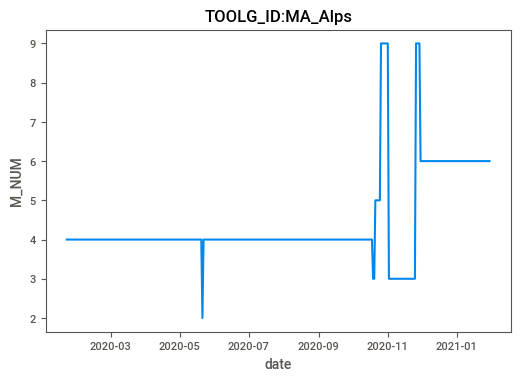

In [327]:
plt.title('TOOLG_ID:'+ df_train['TOOLG_ID'].iloc[0])

plt.ylabel("M_NUM")
plt.xlabel("date")
plt.plot(df_train['MFG_DATE'] , df_train['M_NUM'])
# plt.savefig('./'+df['TOOLG_ID'].iloc[0]+'.pdf',width=600, height=350)
plt.show()


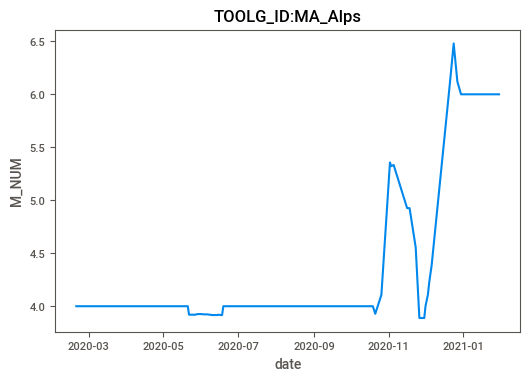

In [328]:


#刪除偏離值
# df_train_sum28_1  =iqrfilter(df_train_sum28,'TRCT',[.25, 1]) 
plt.title('TOOLG_ID:'+ df_train_sum28['TOOLG_ID'].iloc[0])
plt.ylabel("M_NUM")
plt.xlabel("date")
plt.plot(df_train_sum28['MFG_DATE'] , df_train_sum28['M_NUM'])
# plt.savefig('./'+df['TOOLG_ID'].iloc[0]+'.pdf',width=600, height=350)
plt.show()



df_train_sum28_1 = df_train_sum28[df_train_sum28['MFG_DATE'] <  pd.to_datetime(final_date)]

df_train_sum28.to_csv('./data/df_train_sum28.csv')

In [329]:
df_train_sum28_1

,TOOLG_ID,MFG_DATE,M_NUM,UP_TIME,C_UP_TIME,LOT_SIZE,C_LOT_SIZE,EQP_UTIL,C_EQP_UTIL,U,...,ARRIVAL_WIP_QTY,RUN_WIP_RATIO,C_TC,HOLD_RATE,ENG_LOT_RATE,HOT_LOT_RATE,QUE_LOT_RATE,MOVE_QTY,IS_HOLIDAY,TRCT
0,MA_Alps,2020-02-20,4.0,0.796522,0.158710,24.333333,0.170070,0.659043,0.626683,0.629920,...,38.791667,0.577606,0.930523,0.147727,0.000000,0.029505,0.359326,949.0,1.0000,0.079031
1,MA_Alps,2020-02-21,4.0,0.791373,0.159770,22.162162,0.186280,0.671628,0.614839,0.623253,...,36.260870,0.575899,0.888425,0.102133,0.006098,0.000000,0.304878,820.0,1.0000,0.060976
2,MA_Alps,2020-02-22,4.0,0.775242,0.164124,23.486486,0.176583,0.675225,0.613278,0.618523,...,74.083333,0.578656,0.903416,0.000000,0.000000,0.044879,0.445339,1738.0,1.0527,0.113349
3,MA_Alps,2020-02-23,4.0,0.771186,0.164752,22.628571,0.182367,0.677944,0.611971,0.610763,...,64.041667,0.580348,0.900911,0.013696,0.000000,0.106061,0.640152,1584.0,1.0527,0.094697
4,MA_Alps,2020-02-24,4.0,0.770307,0.165032,23.457627,0.176455,0.680515,0.610812,0.610802,...,64.041667,0.576947,0.896096,0.010174,0.000000,0.088150,0.603324,1384.0,1.0000,0.162572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,MA_Alps,2021-01-13,6.0,0.856803,0.157070,25.555556,0.165319,0.497908,0.867319,0.350773,...,12.550000,0.606980,0.000000,0.000000,0.000000,0.000000,1.000000,223.0,1.0000,0.349776
295,MA_Alps,2021-01-14,6.0,0.858486,0.156676,24.222222,0.174408,0.474576,0.900880,0.356662,...,12.250000,0.614403,0.000000,0.000000,0.000000,0.059633,0.483945,427.0,1.0000,0.058548
296,MA_Alps,2021-01-15,6.0,0.859741,0.156449,22.650000,0.186588,0.465667,0.916017,0.352346,...,17.416667,0.667034,0.000000,0.067873,0.000000,0.000000,0.492274,439.0,1.0000,0.052392
297,MA_Alps,2021-01-16,6.0,0.853970,0.157718,22.370370,0.188915,0.485871,0.881211,0.347313,...,27.291667,0.663901,0.000000,0.010291,0.013245,0.000000,0.259934,583.0,1.0527,0.128645


In [330]:
# EDA(df_train_sum28_1,'TRCT')

## 計算測試集資料 取28天平均 df

In [331]:
df = pd.DataFrame(columns = df_train.columns)

# for i in range(1,15):
for i in range(1,((df_train['MFG_DATE'].max()- datetime.datetime.strptime(final_date, "%Y-%m-%d")).days)+2 ):
    _final_date =   datetime.datetime.strptime(final_date, "%Y-%m-%d")+ datetime.timedelta(days=i)
 
    _df = getsum28(df_train,_final_date)
    df = df.append(_df,ignore_index=True)
    
# print(df.shape)
# print(df.describe())

df.to_csv('./data/MyToday20200120_CT.csv')

2021-01-18 00:00:00
2021-01-19 00:00:00
2021-01-20 00:00:00
2021-01-21 00:00:00
2021-01-22 00:00:00
2021-01-23 00:00:00
2021-01-24 00:00:00
2021-01-25 00:00:00
2021-01-26 00:00:00
2021-01-27 00:00:00
2021-01-28 00:00:00
2021-01-29 00:00:00
2021-01-30 00:00:00


## 1. 28 均值 訓練 跑 LR


In [332]:
#實際值
df_test_real =  df_train[df_train['MFG_DATE'] >=  pd.to_datetime(final_date)]


In [333]:
# def_result[def_result['TRCT'] ==0]]

# def :計算準確率 accsum

In [334]:
def accsum(def_result):
    _accsum=0
    def_result[def_result['TRCT'] ==0.0]['TRCT']  =0.0001
    def_result[def_result['predict'] <0]['predict']  =0
    for index,row in def_result.iterrows():
        if row['TRCT'] <0 :
            row['TRCT']  =0.00001
        if row['TRCT'] ==0.0:
            row['TRCT']  =0.00001
        # print(row['TRCT'] )
        if 1- abs((row['predict'] - row['TRCT'])/row['TRCT'] ) >0 :
            
            _accsum+=(1- abs((row['predict'] - row['TRCT'])/row['TRCT'] ))
    
    return _accsum/def_result.shape[0]

In [335]:
df_train_sum28_1

,TOOLG_ID,MFG_DATE,M_NUM,UP_TIME,C_UP_TIME,LOT_SIZE,C_LOT_SIZE,EQP_UTIL,C_EQP_UTIL,U,...,ARRIVAL_WIP_QTY,RUN_WIP_RATIO,C_TC,HOLD_RATE,ENG_LOT_RATE,HOT_LOT_RATE,QUE_LOT_RATE,MOVE_QTY,IS_HOLIDAY,TRCT
0,MA_Alps,2020-02-20,4.0,0.796522,0.158710,24.333333,0.170070,0.659043,0.626683,0.629920,...,38.791667,0.577606,0.930523,0.147727,0.000000,0.029505,0.359326,949.0,1.0000,0.079031
1,MA_Alps,2020-02-21,4.0,0.791373,0.159770,22.162162,0.186280,0.671628,0.614839,0.623253,...,36.260870,0.575899,0.888425,0.102133,0.006098,0.000000,0.304878,820.0,1.0000,0.060976
2,MA_Alps,2020-02-22,4.0,0.775242,0.164124,23.486486,0.176583,0.675225,0.613278,0.618523,...,74.083333,0.578656,0.903416,0.000000,0.000000,0.044879,0.445339,1738.0,1.0527,0.113349
3,MA_Alps,2020-02-23,4.0,0.771186,0.164752,22.628571,0.182367,0.677944,0.611971,0.610763,...,64.041667,0.580348,0.900911,0.013696,0.000000,0.106061,0.640152,1584.0,1.0527,0.094697
4,MA_Alps,2020-02-24,4.0,0.770307,0.165032,23.457627,0.176455,0.680515,0.610812,0.610802,...,64.041667,0.576947,0.896096,0.010174,0.000000,0.088150,0.603324,1384.0,1.0000,0.162572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,MA_Alps,2021-01-13,6.0,0.856803,0.157070,25.555556,0.165319,0.497908,0.867319,0.350773,...,12.550000,0.606980,0.000000,0.000000,0.000000,0.000000,1.000000,223.0,1.0000,0.349776
295,MA_Alps,2021-01-14,6.0,0.858486,0.156676,24.222222,0.174408,0.474576,0.900880,0.356662,...,12.250000,0.614403,0.000000,0.000000,0.000000,0.059633,0.483945,427.0,1.0000,0.058548
296,MA_Alps,2021-01-15,6.0,0.859741,0.156449,22.650000,0.186588,0.465667,0.916017,0.352346,...,17.416667,0.667034,0.000000,0.067873,0.000000,0.000000,0.492274,439.0,1.0000,0.052392
297,MA_Alps,2021-01-16,6.0,0.853970,0.157718,22.370370,0.188915,0.485871,0.881211,0.347313,...,27.291667,0.663901,0.000000,0.010291,0.013245,0.000000,0.259934,583.0,1.0527,0.128645


r2: -0.22362767633346547
MAE: 0.06768933915007082
MSE: 0.004959531646117672
RMSE: 0.07042394227901241
intercept_ : 0.0
r2: 0.5676295289299002
Train acc%: 0.5064138762121904
r2: 0.3925829767355661
Test acc%: 0.5180003286536157
r2: -1.6771285661259512
real acc%: 0.38046269931076715


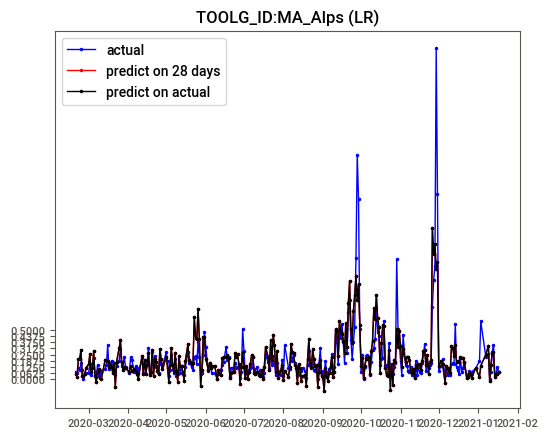

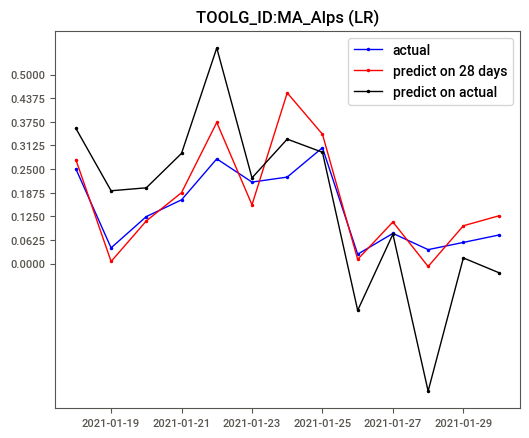

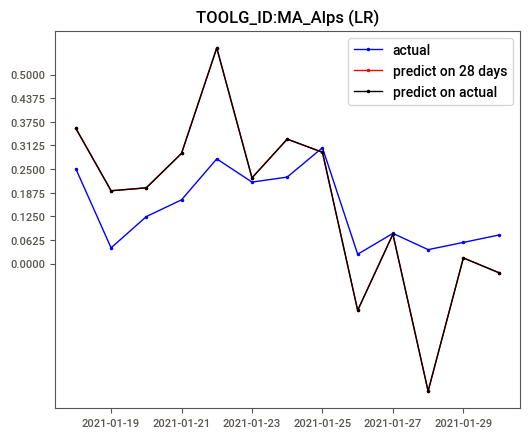

In [336]:
 
trainLR(df_train_sum28_1)
def_result= testLR(df_train_sum28_1,df_train_sum28_1)
 
# print("Train acc%:",sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0])
print("Train acc%:",accsum(def_result))


def_result= testLR(df,df_test_real)
# print("Test acc%:",sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0])
print("Test acc%:",accsum(def_result)) 

def_result= testLR(df_test_real,df_test_real)
print("real acc%:",accsum(def_result))

## 2. 28 均值 訓練 跑 XG

se, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[300, 400, 500, 600, 300, 400, 500, 600, 300, 400, 500,
                   600, 300, 400, 500, 600, 300, 400, 500, 600, 300, 400,
                   500, 600, 300, 400, 500, 600, 300, 400, 500, 600, 300,
                   400, 500, 600, 300, 400, 500, 600, 300, 400, 500, 600,
                   300, 400, 500, 600, 300, 400, 500, 600, 300, 400, 500,
                   600, 300, 400, 500, 600, 300, 400, 500, 600, 300, 400,
                   500, 600, 300, 400, 500, 600, 300, 400, 500, 600, 300,
                   400, 500, 600, 300

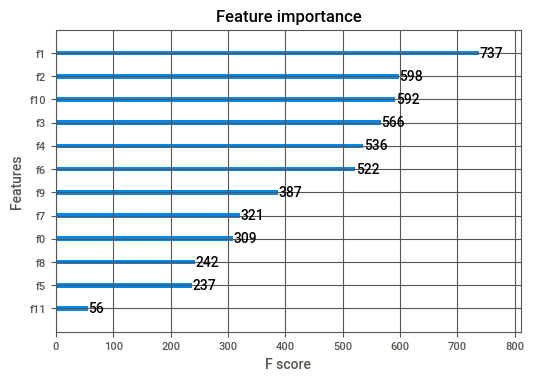

r2: 0.8790862114447958
Train acc%: 0.9049553119851468
r2: 0.017612412400385025
Train acc%: 0.5109577011884066
r2: -0.4505451336691353
real acc%: 0.5237233924719614


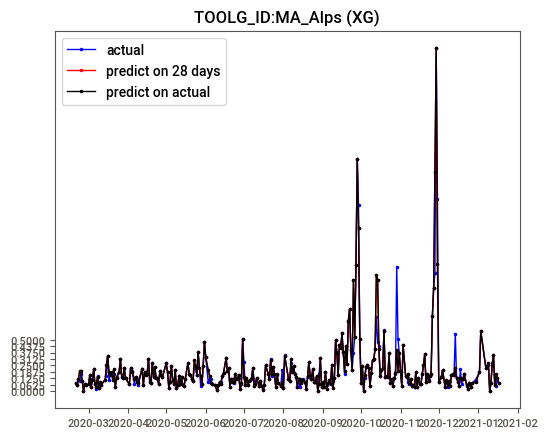

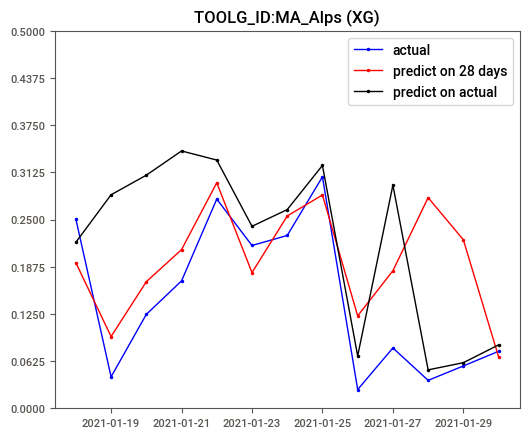

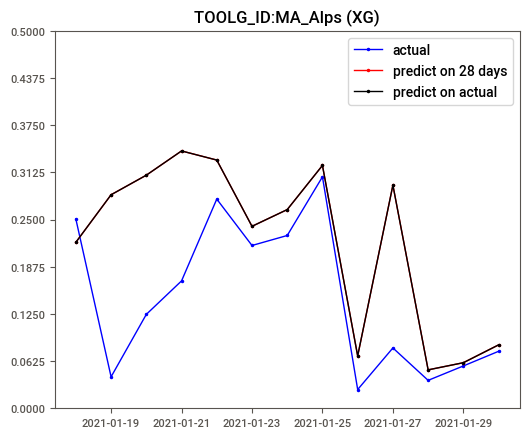

In [337]:

trainXG(df_train_sum28_1)
def_result= testXG(df_train_sum28_1,df_train_sum28_1)

# print("Train acc%:",sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0])
print("Train acc%:",accsum(def_result))

def_result= testXG(df,df_test_real)
# print("Test acc%:",sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0])
print("Train acc%:",accsum(def_result))

def_result= testXG(df_test_real,df_test_real)
print("real acc%:",accsum(def_result))

## 3. 28 均值 訓練 跑 NN

dict_keys(['loss', 'mae', 'mape', 'val_loss', 'val_mae', 'val_mape'])


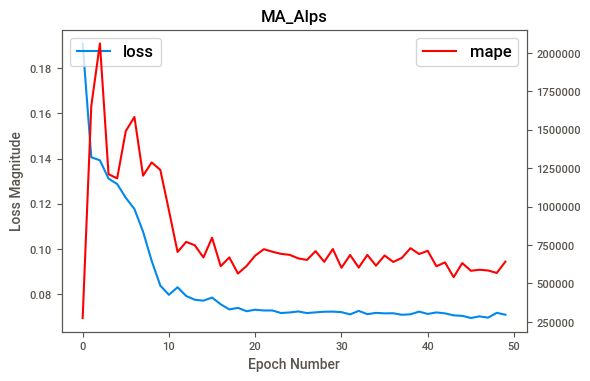

Train acc%: 0.6883018891036395
test acc%: 0.4373037376948943
real acc%: 0.502180415843076


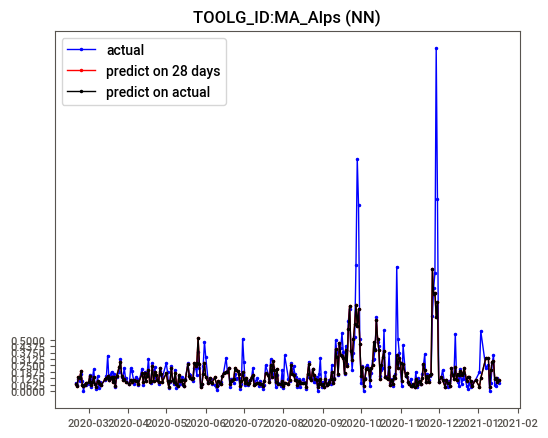

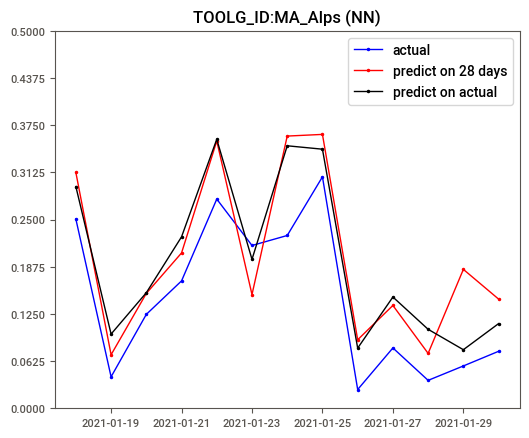

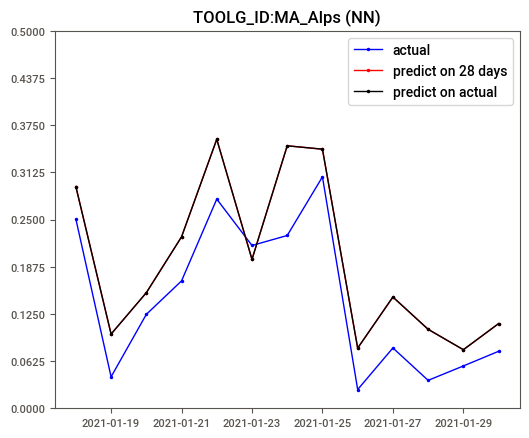

In [338]:
trainNN(df_train_sum28_1)
def_result= testNN(df_train_sum28_1,df_train_sum28_1)
# print("Train acc%:",sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0])
print("Train acc%:",accsum(def_result))

def_result= testNN(df,df_test_real)
print("test acc%:",accsum(def_result))


def_result= testNN(df_test_real,df_test_real)
print("real acc%:",accsum(def_result))

# 訓練並測試模型( 每日歷史資料 訓練)

##  1. 每日歷史資料 跑 LR


r2: -2.831074001447592
MAE: 0.08104332727917063
MSE: 0.009061614357381315
RMSE: 0.09519251208672515
intercept_ : 0.0
r2: 0.715530582200786
train acc%: 0.5346711271097936
r2: 0.540634753632607
test acc%: 0.49196664420998293
r2: -0.36596935879080883
real acc%: 0.47116531303271986


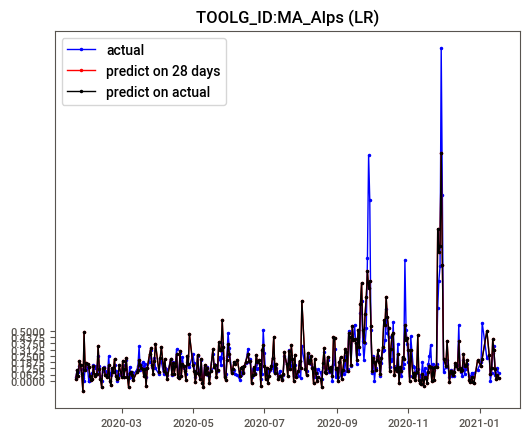

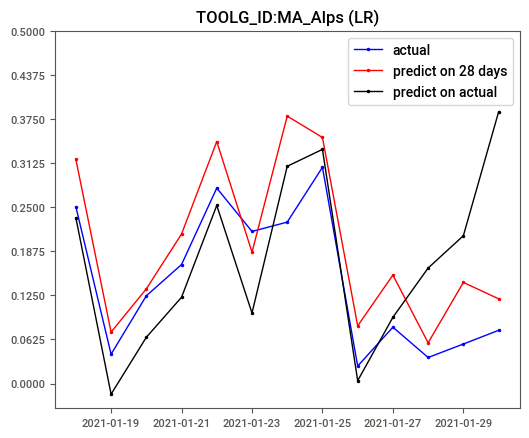

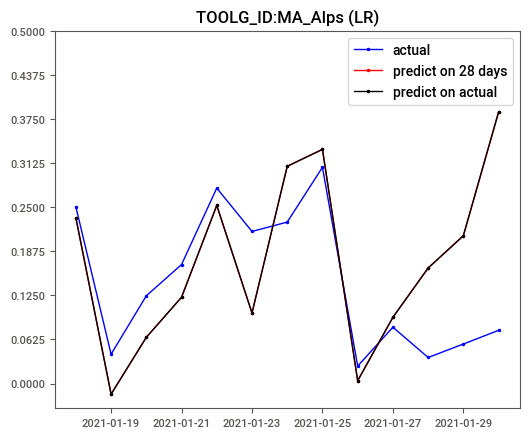

In [339]:
# trainLR(df_train)
#計算準確率分數
trainLR(df_train1)
def_result = testLR(df_train1,df_train1)
# def_result['acc'] = (1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))
# def_result['acc'].sum()/def_result.shape[0]
# sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0]
print("train acc%:",accsum(def_result))
# testLR(df_test_todayOK)
# testLR(df).to_csv('./data/MyToday20200120_result_CT.csv')


#計算準確率分數
def_result = testLR(df,df_test_real)
# testLR( df_train[df_train['MFG_DATE'] ==  pd.to_datetime(final_date)  + datetime.timedelta(days=1)])

# sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0]
print("test acc%:",accsum(def_result))

#計算準確率分數
def_result= testLR(df_test_real,df_test_real)
print("real acc%:",accsum(def_result))




## 2.每日歷史資料 跑 XGBoost


 1, 1, 1, 1, 3, 3, 3, 3, 5, 5, 5, 5,
                   7, 7, 7, 7, 9, 9, 9, 9, 1, 1, 1, 1, 3, 3, 3, 3, 5, 5,
                   5, 5, 7, 7, 7, 7, 9, 9, 9, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
               

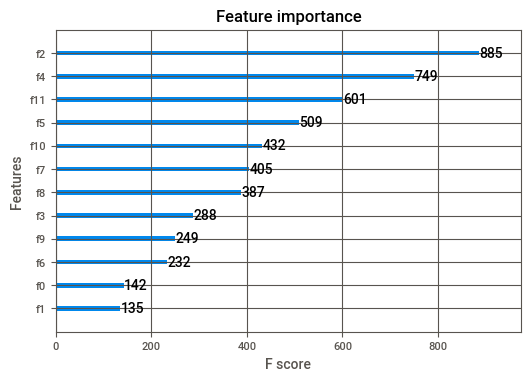

r2: 0.969648743656446
Train acc%: 0.932799172036478
r2: 0.8749030086940718
test acc%: 0.7783717768751607
r2: 0.6838613298775138
real acc%: 0.6426468042161557


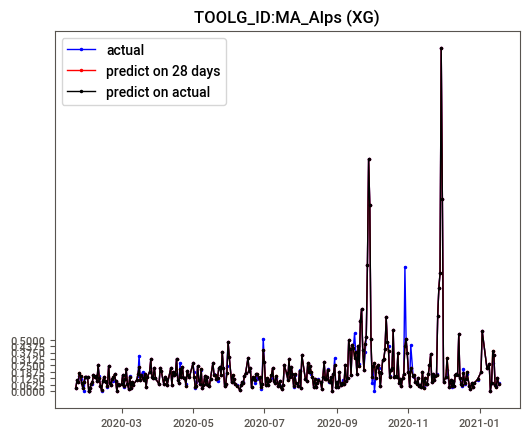

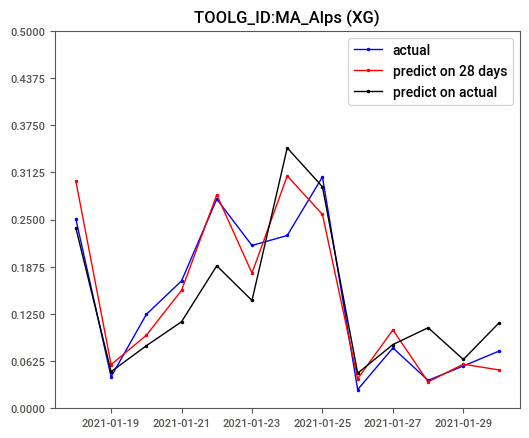

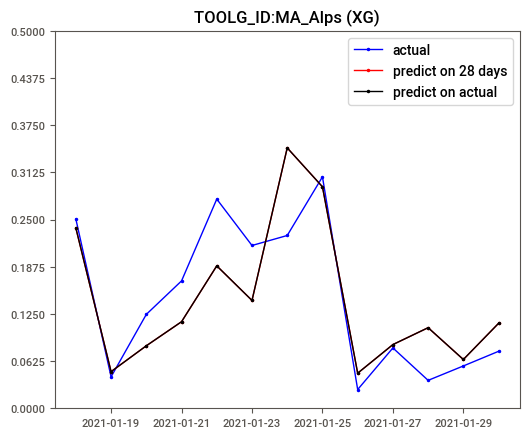

In [340]:
#驗證訓練集 train
trainXG(df_train1)
def_result = testXG(df_train1,df_train1)
# print(sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0])
print("Train acc%:",accsum(def_result)) 
#驗證測試集  test
def_result = testXG(df,df_test_real)
# print(sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0])
print("test acc%:",accsum(def_result)) 

def_result= testXG(df_test_real,df_test_real)
print("real acc%:",accsum(def_result))


In [341]:
df_train1.columns

Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'WIP_QTY', 'NO_HOLD_QTY', 'MOVE_QTY', 'ARRIVAL_WIP_QTY',
       'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE', 'ENG_LOT_RATE', 'HOT_LOT_RATE',
       'QUE_LOT_RATE', 'TRCT'],
      dtype='object')

## 3.每日歷史資料 跑 NN

dict_keys(['loss', 'mae', 'mape', 'val_loss', 'val_mae', 'val_mape'])


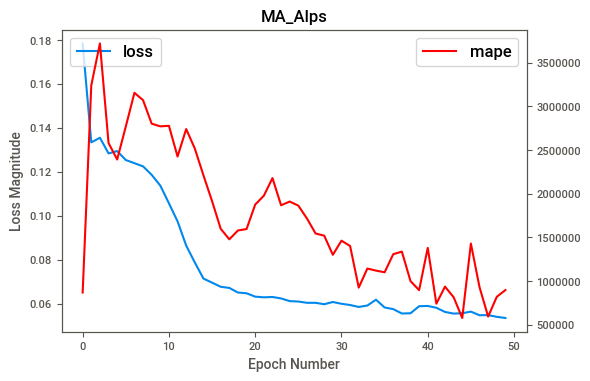

Train acc%: 0.7372012324318074
test acc%: 0.8041644925731457
real acc%: 0.7382821751228502


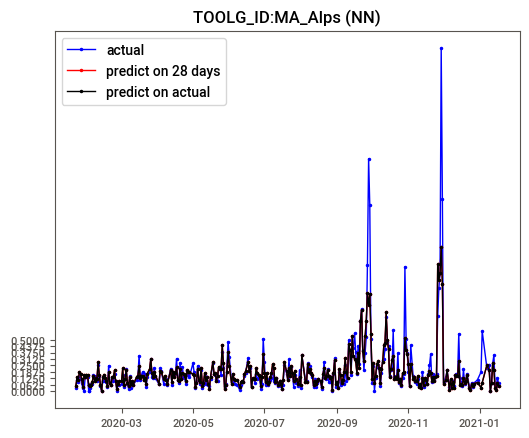

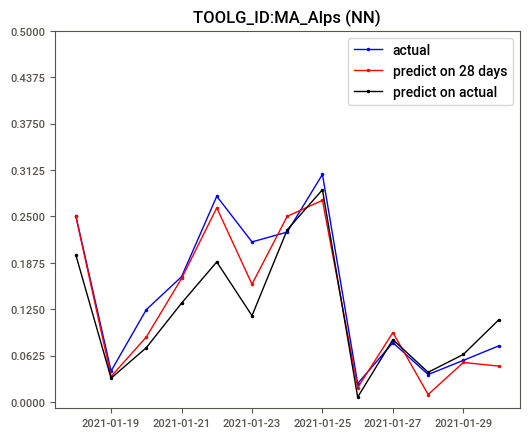

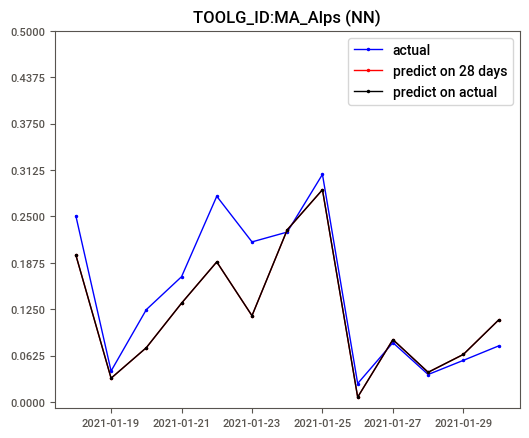

In [352]:
trainNN(df_train1)
def_result = testNN(df_train1,df_train1)
# sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0]
print("Train acc%:",accsum(def_result)) 
def_result = testNN(df,df_test_real)
# sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0]
print("test acc%:",accsum(def_result)) 


def_result= testNN(df_test_real,df_test_real)
print("real acc%:",accsum(def_result))

In [343]:
df_test_real.to_csv("./data/df_test_real.csv")
df_train_sum28_1.to_csv('./data/df_train_sum28_1.csv')
df.to_csv('./data/df.csv')

In [344]:
df_train.columns


Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'WIP_QTY', 'NO_HOLD_QTY', 'MOVE_QTY', 'ARRIVAL_WIP_QTY',
       'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE', 'ENG_LOT_RATE', 'HOT_LOT_RATE',
       'QUE_LOT_RATE', 'TRCT'],
      dtype='object')

In [345]:
def PCA(df):
    from sklearn.preprocessing import StandardScaler #平均&變異數標準化 平均值為0，方差為1。
    from sklearn.preprocessing import MinMaxScaler #最小最大值標準化[0,1]
    from sklearn.preprocessing import RobustScaler #中位數和四分位數標準化
    from sklearn.preprocessing import MaxAbsScaler #絕對值最大標準化
    from sklearn.model_selection import train_test_split
    X,Y = preHandleDat(df,False)
    
    #拆分train validation set
    x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size =0.3, random_state=587)
    # x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=0)
    # standardize the feature 標準化單位方差
    sc = StandardScaler()
    df_pca = df.copy(deep=False)
    x_train_std = sc.fit_transform(df_pca.drop(['MFG_DATE','TOOLG_ID'],axis=1))
    # x_test_std = sc.fit_transform(x_test)
    # print(x_train_std)
 
    # 構造協方差矩陣，得到特徵向量和特徵值
    cov_matrix = np.cov(x_train_std.T)
    eigen_val, eigen_vec = np.linalg.eig(cov_matrix)
    # print("values\n ", eigen_val, "\nvector\n ", eigen_vec)
 
    # 解釋方差比
    tot = sum(eigen_val)  # 總特徵值和
    var_exp = [(i / tot) for i in sorted(eigen_val, reverse=True)]  # 計算解釋方差比，降序
    # print(var_exp)
    # cum_var_exp = np.cumsum(var_exp)  # 累加方差比率
    # plt.rcParams['font.sans-serif'] = ['SimHei']  # 顯示中文
    # plt.bar(range(1, 14), var_exp, alpha=0.5, align='center', label='獨立解釋方差')  # 柱狀 Individual_explained_variance
    # plt.step(range(1, 14), cum_var_exp, where='mid', label='累加解釋方差')  # Cumulative_explained_variance
    # plt.ylabel("解釋方差率")
    # plt.xl         ZAabel("主成分索引")
    # plt.legend(loc='right')
    # plt.show()

    # 特徵變換
    eigen_pairs = [(np.abs(eigen_val[i]), eigen_vec[:, i]) for i in range(len(eigen_val))]
    eigen_pairs.sort(key=lambda k: k[0], reverse=True)  # (特徵值，特徵向量)降序排列
    # print(eigen_pairs)
    w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))  # 降維投影矩陣W
    # print(w)
    x_train_pca = x_train_std.dot(w)
    # print(x_train_pca)
    color = ['r', 'g', 'b']
    marker = ['s', 'x', 'o']
    # for l, c, m in zip(np.unique(y_train), color, marker):
    #     plt.scatter(x_train_pca[y_train == l, 0],
    #                 x_train_pca[y_train == l, 1],
    #                 c=c, label=l, marker=m)
    # plt.title('Result')
    # plt.xlabel('PC1')
    # plt.ylabel('PC2')
    # plt.legend(loc='lower left')
    # plt.show()

In [346]:
# PCA(df_train1)

In [347]:
# def NNTunning():
 
#     from tensorflow.python.ops import summary_ops_v2
#     from tensorflow.python.keras.backend import get_graph
#     #hparam tunning
#     HP_NUM_UNITS_ONE = hp.HParam('num_units_one', hp.Discrete([5, 10, 20]))
#     HP_NUM_UNITS_TWO = hp.HParam('num_units_two', hp.Discrete([10, 20, 40]))
#     HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

#     METRIC_ACCURACY = 'accuracy'

#     with tf.summary.create_file_writer(output_dir).as_default():
#     hp.hparams_config(
#         hparams=[HP_NUM_UNITS_ONE, HP_NUM_UNITS_TWO, HP_OPTIMIZER],
#         metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
#     )
#     model_dict = {}
#     session_num = 0
#     for num_units_one in HP_NUM_UNITS_ONE.domain.values:
#     for num_units_two in HP_NUM_UNITS_TWO.domain.values:
#         for optimizer in HP_OPTIMIZER.domain.values:     
#         hparams = {
#             HP_NUM_UNITS_ONE: num_units_one,
#             HP_NUM_UNITS_TWO: num_units_two,
#             HP_OPTIMIZER: optimizer,
#         }
#         run_name = "run-%d" % session_num
#         print('>> Starting trial: %s' % run_name)
#         print({h.name: hparams[h] for h in hparams})
#         model, accuracy = run(output_dir + run_name, hparams)
#         model_dict[accuracy] = model
#         session_num += 1

#     best_model = model_dict[max(list(model_dict.keys()))]

In [348]:
# def train_test_NNmodel(hparams):  
#   model = tf.keras.models.Sequential()
#   model.add(layers.Dense(hparams[HP_NUM_UNITS_ONE], activation = 'relu',input_shape=(13,)))
#   model.add(layers.Dense(hparams[HP_NUM_UNITS_TWO],activation = 'relu' ))
#   model.add(layers.Dense(1,activation = 'sigmoid' ))
#   model.compile(
#       optimizer=hparams[HP_OPTIMIZER],
#       loss='binary_crossentropy',
#       metrics=['accuracy'],
#   )

#   model.fit(x_train, y_train, epochs=30) 
#   _, accuracy = model.evaluate(x_test, y_test)
#   return model, accuracy

# def runNN(run_dir, hparams):
#   with tf.summary.create_file_writer(run_dir).as_default():
#     hp.hparams(hparams)  # record the values used in this trial
#     model, accuracy = train_test_model(hparams)
#     tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
#   return model, accuracy

In [349]:
np.linspace(0.0,0.7,8)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

In [350]:
# #EDA(df_train1,'TRCT')
# feature_config = sv.FeatureConfig(skip=['LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','WIP_QTY'
# ],  # 要忽略哪個特徵
#                                 #   force_cat=[ 'LOT_ID', 'STATUS', 'CHIPNAME', 'LAYER','PRIORITY', 'LOT_TYPE',  'WS_DATE','IS_MAIN_ROUTE'], # Categorical特徵
#                                 #   force_num=['WIP_QTY','REMAIN_LAYER_SEQ'], # Numerical特徵
#                                   force_text=None
#                                   ) # Text特徵
# pairwise_analysis = 'on'
# my_report = sv.compare([df_train.fillna(0) , "all Data"], [df_test_real.fillna(0) , "Test Data"],  target_feat="TRCT", feat_cfg=feature_config)
# my_report.show_html(filepath='./sweetvizHTML/df_train.html' ) # 儲存為html的格式

In [351]:
# EDA(df_train_sum28_1,'TRCT')